# Quantum Repeater Design - Purification Strategy Test

## Heralded Quantum Repeater

### Components

* QGen - perform entangled photons/qubits generation
* QSwap - performing quantum entanglement swapping
* Alice - represents sender
* Bob - represents destination/recipient
* QMem - stores qubits awaiting swapping protocol

In [139]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ, transpile, execute
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity, DensityMatrix
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.circuit import Instruction, Gate
from qiskit.circuit.library import RXGate
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info.analysis import hellinger_fidelity

In [140]:
def get_device_noise_model() -> (AerSimulator, NoiseModel):
    provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                       not b.configuration().simulator and b.status().operational==True))
    backend = AerSimulator.from_backend(backend)

    noise_model = NoiseModel.from_backend(backend)
    return backend, noise_model

In [141]:
backend, noise_model = get_device_noise_model()

ibmqfactory.load_account:WARNING:2022-10-19 07:16:39,577: Credentials are already in use. The existing account in the session will be replaced.
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxati

In [142]:
print("Backend:\n", backend)
print("\nNoise Model:\n", noise_model)

Backend:
 aer_simulator(ibmq_belem)

Noise Model:
 NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['id', 'measure', 'sx', 'cx', 'reset', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1

In [143]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b).c_if(bsm_x, 1)
        qc.z(b).c_if(bsm_z, 1)

In [144]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [145]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        # result = execute(qc, qasm_sim, shots=10240).result()
        result = execute(qc, qasm_sim, shots=10240, noise_model=noise_model).result()
        return result.get_counts()
        # return qasm_sim.run(transpile(qc, qasm_sim), shots=10240).result().get_counts()

In [146]:
def get_count_from_duplicate_circuit(c: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> (QuantumCircuit,Counts):
    qcn: QuantumCircuit = c.copy(name="qcn")
    qcn.barrier()
    qcn.measure(a, 0)
    qcn.measure(b, 1)
    qcn_counts: Counts = qns.qasm_sim(qcn)
    return (qcn, qcn_counts)

In [147]:
def get_fidelities_dict(dc: dict) -> dict:
    # compare fidelities
    dictlen: int = len(dc)
    dict_fids = {}

    for i in range(dictlen):
        if i == dictlen - 1:
            break
        cur: str = list(dc.keys())[0]
        nxt: str = list(dc.keys())[i + 1]
        fidelity: float = hellinger_fidelity(dc[cur], dc[nxt])
        f = "F("+cur+","+nxt+")"
        dict_fids[f] = fidelity
    return dict_fids

In [148]:
def full_deutsch_purification() -> Gate:
    c = QuantumCircuit(6, name="Full Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [4])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [5])

    c.cx(0, 2)
    c.cx(0, 4)

    c.cx(1, 5)
    c.cx(1, 3)
    c.to_gate(label="Full Deutsch")
    return c

In [149]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()
qv: QuantumVisualizations = QuantumVisualizations()

dict_counts: dict= {}

In [150]:
def fidelity_analysis(strategy: str = None) -> (QuantumCircuit, Counts) :
    alice: QuantumRegister = QuantumRegister(2, "alice")
    charlie: QuantumRegister = QuantumRegister(2, "charlie")
    bob: QuantumRegister = QuantumRegister(2, "bob")

    bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
    bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

    coz: ClassicalRegister = ClassicalRegister(1, "coz")
    cox: ClassicalRegister = ClassicalRegister(1, "cox")

    qc: QuantumCircuit = QuantumCircuit(alice, charlie, bob, bsm_z, bsm_x, coz, cox)
    
    dict_counts.clear()
    
    qco.create_bell_pairs(qc, [alice, charlie, bob])
    # purification after bell pair creation
    if strategy == "abpc":
        qc.append( full_deutsch_purification(), [alice[0], alice[1], charlie[0], charlie[1], bob[0], bob[1]] )
    # count after bell pair creation
    qc_abpc, count_abpc = get_count_from_duplicate_circuit(qc, alice[0], alice[1])
    dict_counts["count_abpc"] = count_abpc
    
    # count after entanglement after distribution/transmission
    qc_dist, count_dist = get_count_from_duplicate_circuit(qc, alice[0], alice[1])
    dict_counts["count_dist"] = count_dist
    
    qco.bell_state_operation(qc, [alice[1], charlie[0]])
    qco.bell_state_measurement(qc, [alice[1], charlie[0]])
    qco.pauli_correction_operation(qc, charlie[1], bsm_z, bsm_x)
    # purification after first swap protocol
    if strategy == "aswap1" or strategy == "swap":
        qc.append( full_deutsch_purification(), [alice[0], alice[1], charlie[0], charlie[1], bob[0], bob[1]] )
    # count after first stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], charlie[1])
    dict_counts["count_aswap1"] = count_aswap

    qco.bell_state_operation(qc, [charlie[1], bob[0]])
    qco.bell_state_measurement(qc, [charlie[1], bob[0]])
    qco.pauli_correction_operation(qc, bob[1], bsm_z, bsm_x)
    # purification after second swap protocol
    if strategy == "aswap2" or strategy == "swap":
        qc.append( full_deutsch_purification(), [alice[0], alice[1], charlie[0], charlie[1], bob[0], bob[1]] )
    # count after second stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], bob[1])
    dict_counts["count_aswap2"] = count_aswap
    
    qc.barrier()
    qc.cx(alice[0], bob[1])
    qc.h(alice[0])
    
    qc.barrier()
    qc.measure(alice[0], coz)
    qc.measure(bob[1], cox)

    counts: Counts = qns.qasm_sim(qc)
    dict_counts["count_end"] = counts
    
    return (qc, counts)

### Without Purification

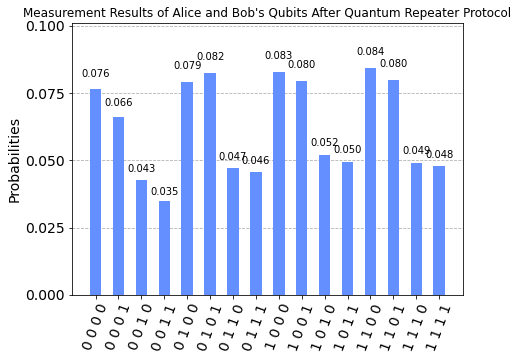

In [151]:
circ, counts = fidelity_analysis()
# dict_counts_wp: dict = dict_counts
dict_fids_wp: dict = get_fidelities_dict(dict_counts)
plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

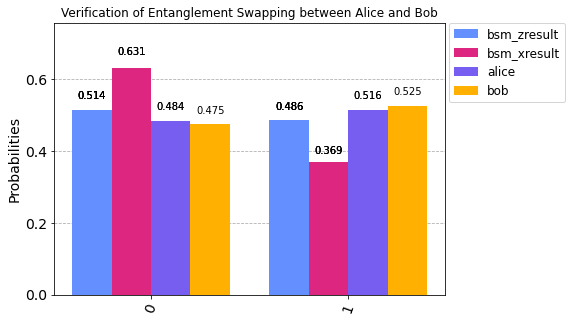

In [152]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["bsm_zresult", "bsm_xresult", "alice", "bob"]
plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

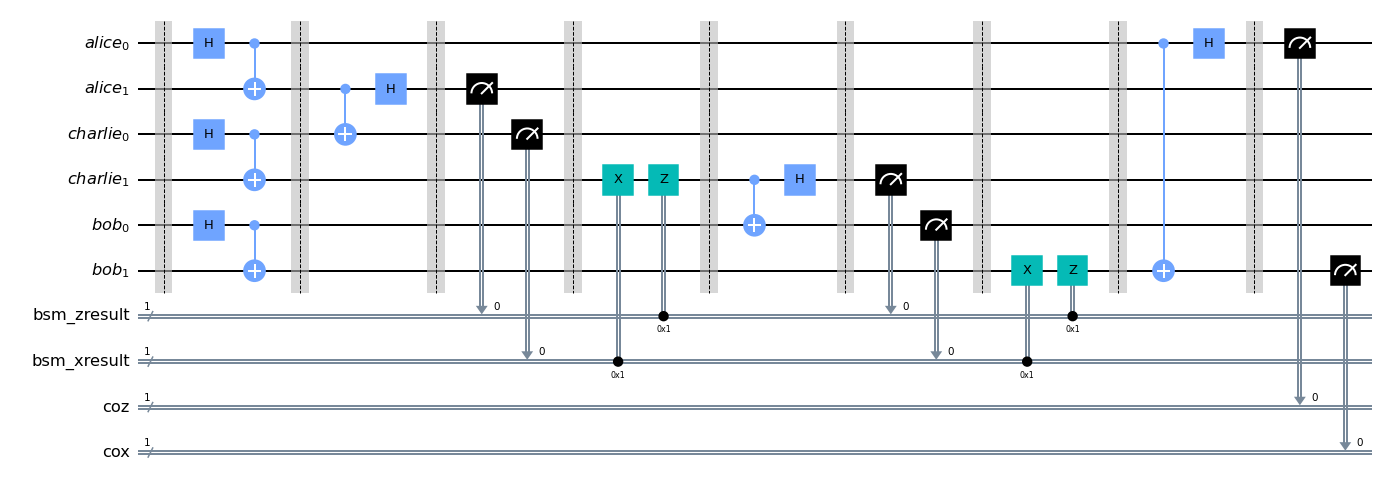

In [153]:
circ.draw("mpl", fold=-1)

### With Purification After Bell-pair production

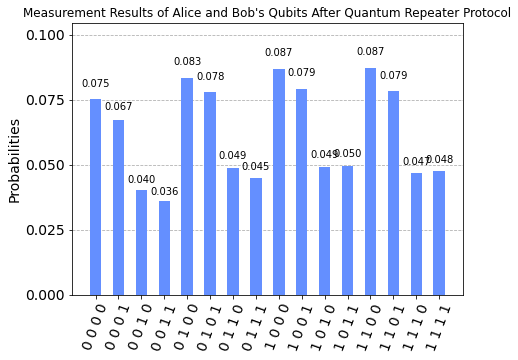

In [154]:
circ, counts = fidelity_analysis("abpc")
# dict_counts_wp: dict = dict_counts
dict_fids_abpc: dict = get_fidelities_dict(dict_counts)
plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

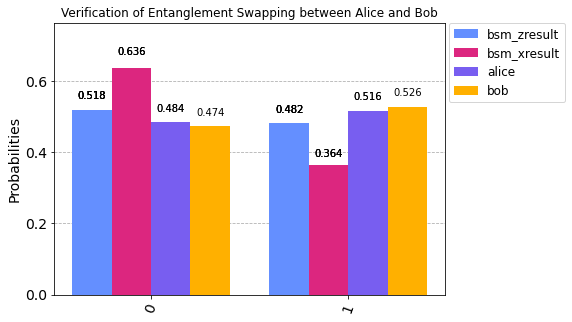

In [155]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["bsm_zresult", "bsm_xresult", "alice", "bob"]
plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

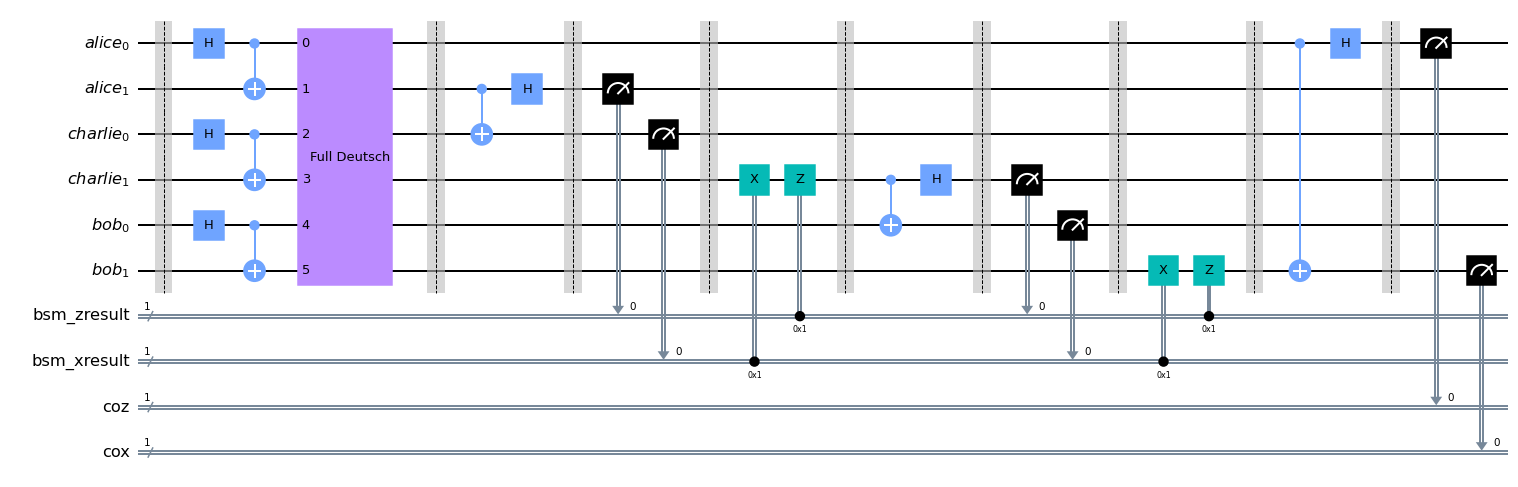

In [156]:
circ.draw("mpl", fold=-1)

### With Purification After Every Swap

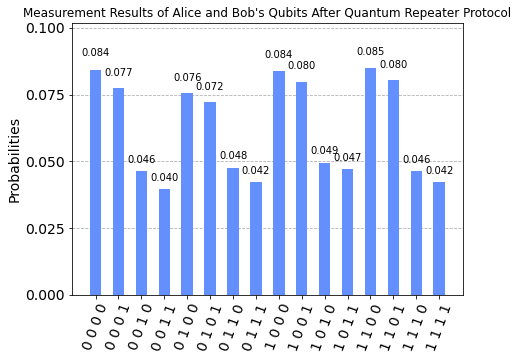

In [157]:
circ, counts = fidelity_analysis("swap")
# dict_counts_wp: dict = dict_counts
dict_fids_swap: dict = get_fidelities_dict(dict_counts)
plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

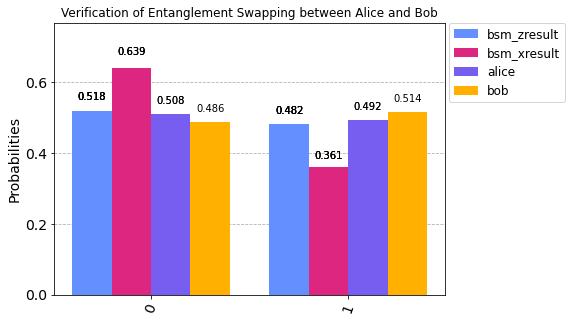

In [158]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["bsm_zresult", "bsm_xresult", "alice", "bob"]
plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

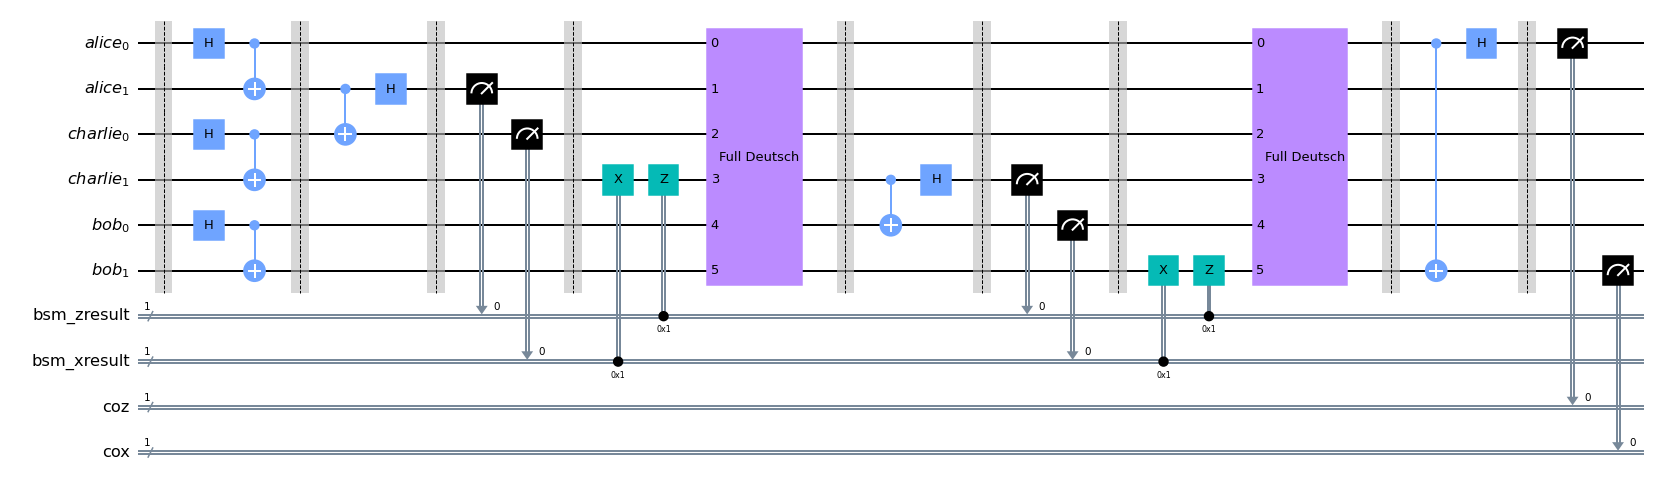

In [159]:
circ.draw("mpl", fold=-1)

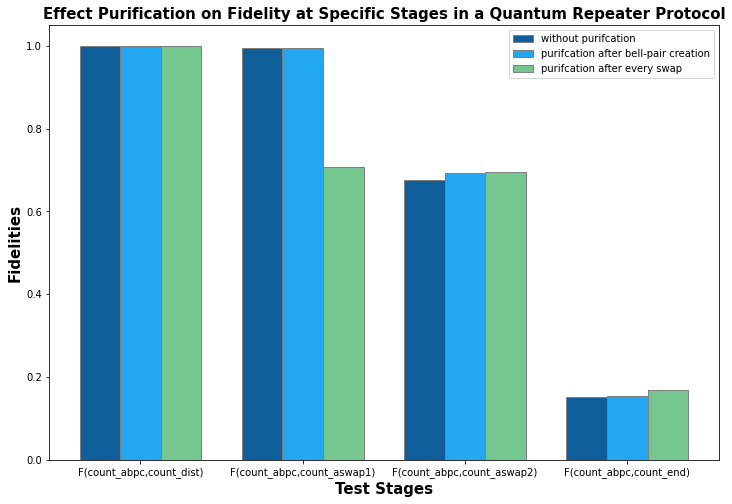

In [168]:
barwidth = 0.25
# fig = plt.figure(figsize = (10, 5))
fig = plt.subplots(figsize =(12, 8))

x_axis = np.arange(len(dict_fids_wp))

#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]


# without purification
x = list(dict_fids_wp.keys())
y = list(dict_fids_wp.values())
plt.bar(x_axis, y, width=barwidth, color="#115f9a", edgecolor="grey", label="without purifcation")

# with purification after bell pair creation
x = list(dict_fids_abpc.keys())
y = list(dict_fids_abpc.values())
plt.bar( [k + barwidth for k in x_axis], y, width=barwidth, color="#22a7f0", edgecolor="grey", label="purifcation after bell-pair creation")

# with purification after every swap
x = list(dict_fids_swap.keys())
y = list(dict_fids_swap.values())
plt.bar( [k + 2*barwidth for k in x_axis], y, width=barwidth, color="#76c68f", edgecolor="grey", label="purifcation after every swap")

plt.ylabel("Fidelities", fontweight="bold", fontsize=15)
plt.xlabel("Test Stages", fontweight="bold", fontsize=15)
plt.xticks(x_axis, list(dict_fids_wp.keys()))
plt.xticks( [k + barwidth for k in range(len(dict_fids_wp))], list(dict_fids_wp.keys()) )

plt.title("Effect Purification on Fidelity at Specific Stages in a Quantum Repeater Protocol", fontweight="bold", fontsize=15)
plt.legend()
plt.show()